In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def configure_gpu():
    """Configure GPU for efficient training."""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth to avoid allocating all GPU memory
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        except Exception as e:
            print(f"GPU Configuration Error: {e}")

In [3]:
def configure_tpu():
    """Configure TPU for efficient training."""
    try:
        # Detect and initialize the TPU
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Automatically detects the TPU
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)  # Create a strategy for distributed training
        print("TPU initialized successfully.")
        return strategy
    except ValueError as e:
        print(f"TPU Configuration Error: {e}. Check if TPU runtime is enabled.")
        return None

In [4]:
df = pd.read_csv('/content/Electric_Vehicle_Population_Data.csv')

In [5]:
df[['Longitude', 'Latitude']] = df['Vehicle Location'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')
df['Longitude'] = pd.to_numeric(df['Longitude'])
df['Latitude'] = pd.to_numeric(df['Latitude'])
df.drop('Vehicle Location', axis=1, inplace=True)
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,-122.308390,47.610365
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,PUGET SOUND ENERGY INC,5.306105e+10,-122.179458,47.802589
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,-122.348480,47.632405
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,-122.036460,47.534065
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,23.0,205138552,PUGET SOUND ENERGY INC,5.303594e+10,-122.557170,47.733415


In [6]:
print((df['Base MSRP'] == 0).count())
print((df['Electric Range'] == 0).count())

177866
177866


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 18 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

In [8]:
df.isna().sum()

,0
VIN (1-10),0
County,5
City,5
State,0
Postal Code,5
Model Year,0
Make,0
Model,0
Electric Vehicle Type,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0


In [9]:
df.dropna(inplace=True)

In [10]:
numeric_df = df.select_dtypes(include='number')

In [11]:
df[numeric_df.columns] = numeric_df.apply(lambda x: x.astype(int))

In [12]:
df.duplicated().sum()

0

In [13]:
print(df.groupby('Make')['Model'].unique())
print(df['Model Year'].unique())
print(df['Electric Vehicle Type'].unique())
print(df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique())

Make
ALFA ROMEO                                                       [TONALE]
AUDI                    [Q5 E, E-TRON, A3, Q4, E-TRON SPORTBACK, RS E-...
AZURE DYNAMICS                                 [TRANSIT CONNECT ELECTRIC]
BENTLEY                                           [FLYING SPUR, BENTAYGA]
BMW                     [X5, I3, I8, X3, 330E, I4, I5, 530E, IX, 745E,...
CADILLAC                                                [LYRIQ, ELR, CT6]
CHEVROLET               [BOLT EV, VOLT, SPARK, BOLT EUV, BLAZER EV, SI...
CHRYSLER                                                       [PACIFICA]
DODGE                                                            [HORNET]
FIAT                                                                [500]
FISKER                                                     [OCEAN, KARMA]
FORD                    [FUSION, C-MAX, ESCAPE, F-150, MUSTANG MACH-E,...
GENESIS                                                 [GV60, GV70, G80]
GMC                              

<ipython-input-14-ffe5f28bad6e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_per_year.index, y=count_per_year.values, palette='viridis')


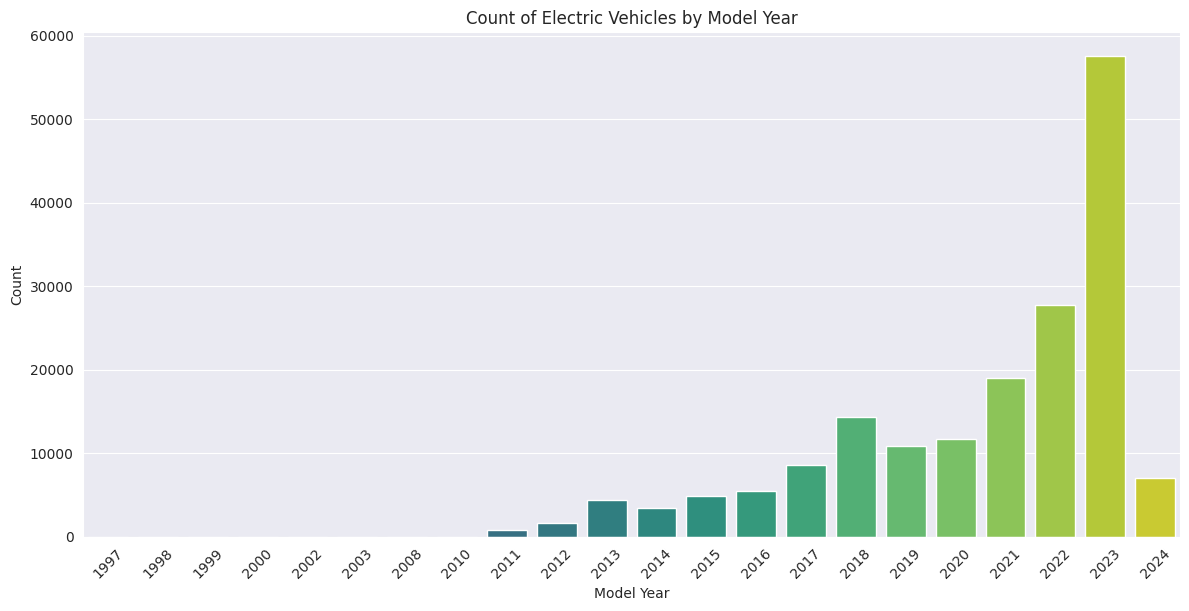

In [14]:
count_per_year = df['Model Year'].value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.barplot(x=count_per_year.index, y=count_per_year.values, palette='viridis')
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.title('Count of Electric Vehicles by Model Year')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

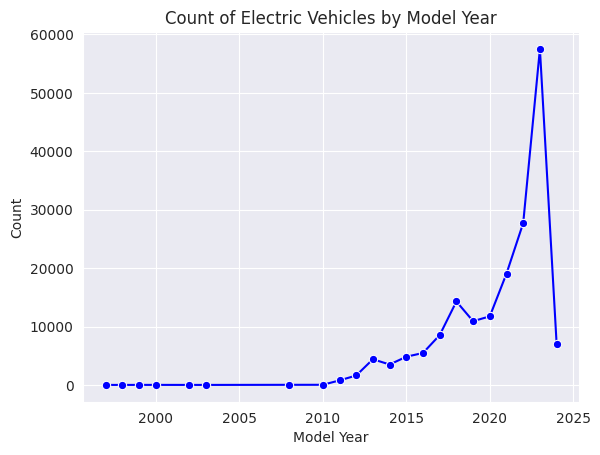

In [15]:
sns.lineplot(x=count_per_year.index, y=count_per_year.values, marker='o', color='blue')
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.title('Count of Electric Vehicles by Model Year')
plt.grid(True)
plt.show()

In [16]:
df['Electric Range'].describe()

,Electric Range
count,177473.000000
mean,58.826548
std,91.973457
min,0.000000
25%,0.000000
50%,0.000000
75%,75.000000
max,337.000000


<ipython-input-17-d55bc11276e2>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_models_per_make = make_model_grouped.groupby('Make').apply(lambda x: x.nlargest(3, 'Electric Range')).reset_index(drop=True)


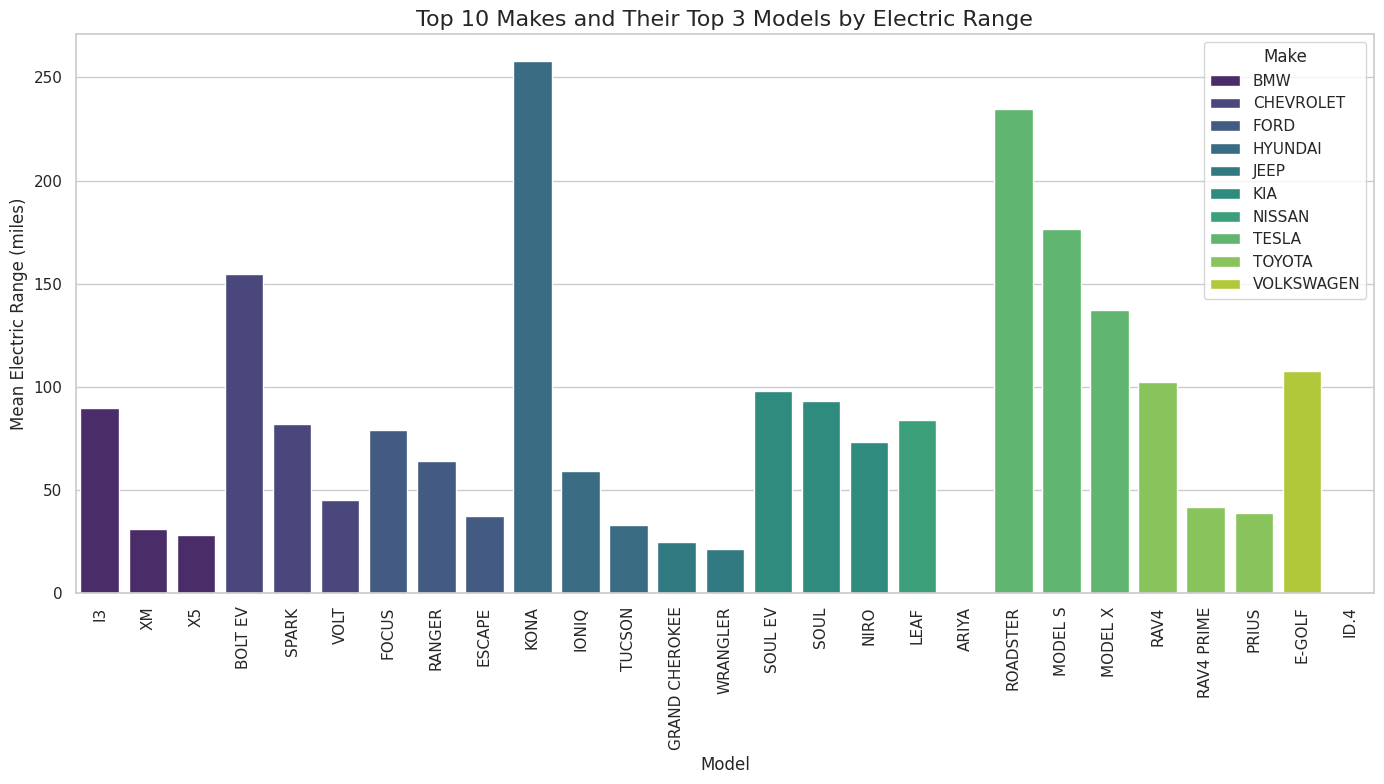

In [17]:
top_10_makes = df['Make'].value_counts().head(10).index
top_10_makes_df = df[df['Make'].isin(top_10_makes)]
make_model_grouped = top_10_makes_df.groupby(['Make', 'Model'], as_index=False)['Electric Range'].mean()
top_5_models_per_make = make_model_grouped.groupby('Make').apply(lambda x: x.nlargest(3, 'Electric Range')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
plot = sns.barplot(data=top_5_models_per_make, x='Model', y='Electric Range', hue='Make', palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 10 Makes and Their Top 3 Models by Electric Range', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Electric Range (miles)', fontsize=12)
plt.tight_layout()
plt.show()

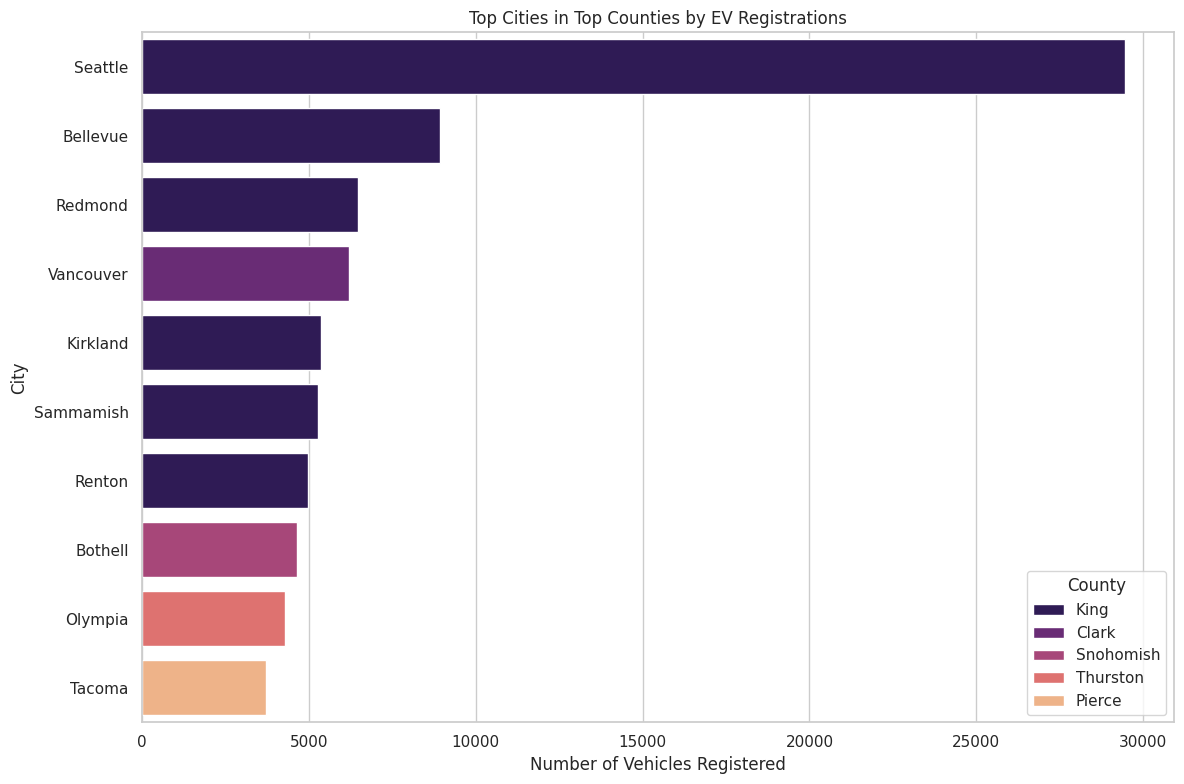

In [18]:
county_distribution = df['County'].value_counts()
top_10_counties = county_distribution.head(10).index
top_10_counties_df = df[df['County'].isin(top_10_counties)]
top_10_counties_df = top_10_counties_df.groupby(['County', 'City']).size().sort_values(ascending=False).reset_index(name='Number of Vehicles')
top_cities_df = top_10_counties_df.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Vehicles', y='City', hue='County', data=top_cities_df, palette="magma")
plt.title('Top Cities in Top Counties by EV Registrations')
plt.xlabel('Number of Vehicles Registered')
plt.ylabel('City')
plt.legend(title='County')
plt.tight_layout()
plt.show()

In [19]:
vehicle_counts_by_year = df[df['Model Year'] < 2024].groupby('Model Year').size().reset_index(name='Count')

vehicle_counts_by_year['Growth Rate (%)'] = vehicle_counts_by_year['Count'].pct_change() * 100
print(vehicle_counts_by_year)

    Model Year  Count  Growth Rate (%)
0         1997      1              NaN
1         1998      1         0.000000
2         1999      5       400.000000
3         2000      7        40.000000
4         2002      2       -71.428571
5         2003      1       -50.000000
6         2008     19      1800.000000
7         2010     23        21.052632
8         2011    775      3269.565217
9         2012   1614       108.258065
10        2013   4399       172.552664
11        2014   3496       -20.527393
12        2015   4826        38.043478
13        2016   5469        13.323663
14        2017   8534        56.043152
15        2018  14286        67.400984
16        2019  10913       -23.610528
17        2020  11740         7.578118
18        2021  19063        62.376491
19        2022  27708        45.349630
20        2023  57519       107.589866


In [20]:
df = df[df['Model Year'] < 2024]
print(df.isnull().sum())

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Electric Utility                                     0
2020 Census Tract                                    0
Longitude                                            0
Latitude                                             0
dtype: int

In [21]:
df[df.isna().any(axis=1)]

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude


In [22]:
source_df = df[(df['Electric Range'] > 0) & (df['Base MSRP'] > 0)]

<Axes: >

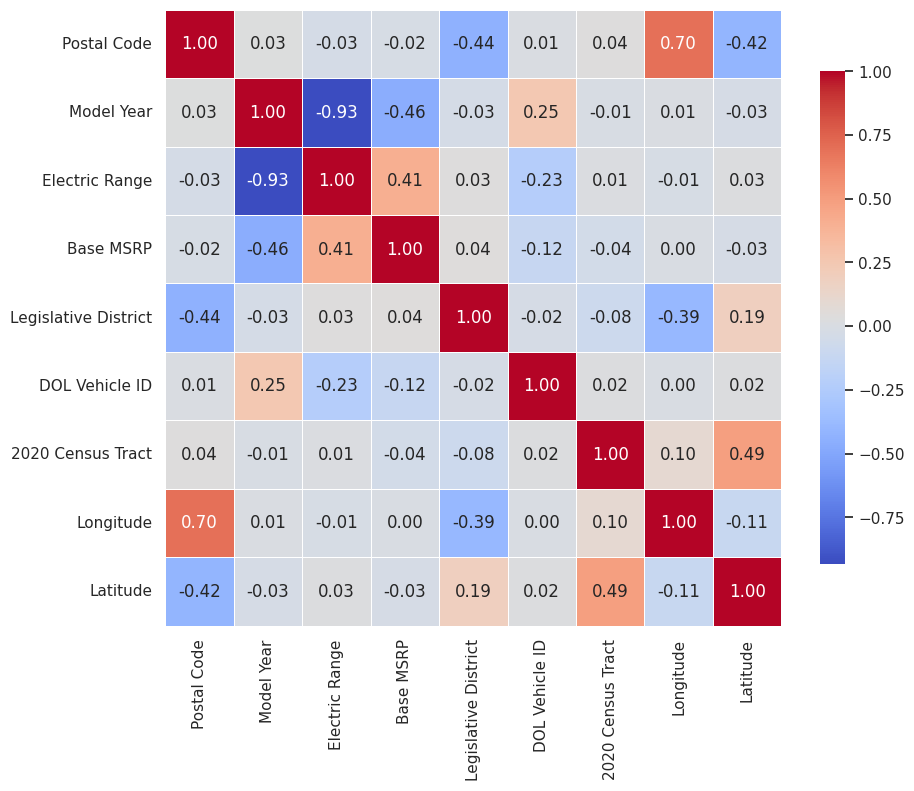

In [24]:
pred_numeric_df = source_df.select_dtypes(include='number')
corelation = pred_numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

sns.heatmap(
    corelation,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'shrink': 0.8},
    linewidths=0.5,
    square=True
)

In [25]:
pred_source_df = source_df.drop(columns=['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Legislative District', 'DOL Vehicle ID', 'Electric Utility', '2020 Census Tract', 'Longitude', 'Latitude'])

In [26]:
pred_source_df = pd.get_dummies(pred_source_df, columns=['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'], dtype=int)

In [27]:
pred_source_df['Make_Model'] = pred_source_df['Make'] + '_' + pred_source_df['Model']
pred_source_df = pred_source_df.drop(columns=['Make', 'Model'])

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pred_source_df['Make_Model'] = le.fit_transform(pred_source_df['Make_Model'])
pred_source_df

,Model Year,Electric Range,Base MSRP,Electric Vehicle Type_Battery Electric Vehicle (BEV),Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible,Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range,Make_Model
30,2017,93,32250,1,0,1,0,7
71,2016,93,31950,1,0,1,0,6
187,2013,208,69900,1,0,1,0,13
218,2013,208,69900,1,0,1,0,13
293,2017,14,44100,0,1,0,1,0
...,...,...,...,...,...,...,...,...
177581,2016,93,31950,1,0,1,0,6
177591,2017,93,32250,1,0,1,0,7
177605,2013,208,69900,1,0,1,0,13
177723,2019,17,52900,0,1,0,1,15


In [29]:
print(pred_source_df['Make_Model'].nunique())

18


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = pred_source_df.drop(columns=['Electric Range', 'Base MSRP'])
y = pred_source_df[['Electric Range', 'Base MSRP']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

y_train[['Base MSRP', 'Electric Range']] = scaler.fit_transform(y_train[['Base MSRP', 'Electric Range']])
y_test[['Base MSRP', 'Electric Range']] = scaler.transform(y_test[['Base MSRP', 'Electric Range']])

In [31]:
X_train

,Model Year,Electric Vehicle Type_Battery Electric Vehicle (BEV),Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible,Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range,Make_Model
43983,2013,1,0,1,0,13
73990,2019,0,1,1,0,4
37164,2013,1,0,1,0,13
3429,2014,1,0,1,0,13
106229,2012,1,0,1,0,13
...,...,...,...,...,...,...
58676,2017,0,1,0,1,2
60338,2013,1,0,1,0,13
69399,2014,1,0,1,0,13
46361,2018,0,1,0,1,1


In [32]:
y_train

,Electric Range,Base MSRP
43983,0.774704,0.046676
73990,0.079051,0.009895
37164,0.774704,0.046676
3429,0.774704,0.046676
106229,1.000000,0.034377
...,...,...
58676,0.007905,0.070291
60338,0.774704,0.046676
69399,0.774704,0.046676
46361,0.007905,0.028289


In [33]:
X_test

,Model Year,Electric Vehicle Type_Battery Electric Vehicle (BEV),Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible,Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range,Make_Model
23487,2016,1,0,1,0,6
143104,2013,1,0,1,0,13
73030,2019,0,1,0,1,15
104145,2013,1,0,1,0,13
114288,2017,0,1,0,1,2
...,...,...,...,...,...,...
137737,2013,1,0,1,0,13
147874,2014,1,0,1,0,13
162567,2013,1,0,1,0,13
78925,2018,1,0,1,0,7


In [34]:
y_test

,Electric Range,Base MSRP
23487,0.320158,0.000000
143104,0.774704,0.046676
73030,0.019763,0.025767
104145,0.774704,0.046676
114288,0.007905,0.070291
...,...,...
137737,0.774704,0.046676
147874,0.774704,0.046676
162567,0.774704,0.046676
78925,0.391304,0.002460


In [35]:
!pip install keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [36]:
def build_model(hp, input_shape):
    """Build neural network model with dynamic hyperparameters."""
    model = Sequential()

    # Input layer with BatchNormalization
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Dense(
        units=hp.Int('units_input', min_value=336, max_value=496, step=32),
        activation=hp.Choice('activation_input', ['relu', 'tanh'])
    ))

    # Dynamic hidden layers matching previous configuration
    num_layers = hp.Int('num_layers', 4, 5)
    layer_configs = [
        {'units': 976, 'activation': 'relu', 'dropout': False},
        {'units': 752, 'activation': 'tanh', 'dropout': False},
        {'units': 272, 'activation': 'sigmoid', 'dropout': True},
        {'units': 720, 'activation': 'relu', 'dropout': False},
        {'units': 304, 'activation': 'relu', 'dropout': False}
    ]

    for i in range(num_layers):
        config = layer_configs[i]
        model.add(Dense(
            units=hp.Int(f'units_{i}',
                         min_value=max(100, config['units']-200),
                         max_value=min(1024, config['units']+200),
                         step=32),
            activation=hp.Choice(f'activation_{i}',
                                 ['relu', 'tanh', 'sigmoid'])
        ))

        model.add(BatchNormalization())

        if config['dropout'] or hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(
                rate=hp.Float(f'dropout_rate_{i}',
                              min_value=0.2,
                              max_value=0.4,
                              step=0.1)
            ))

    # Output layer
    model.add(Dense(2, activation='linear'))

    # Optimizer configurations
    optimizer_choice = hp.Choice('optimizer', ['rmsprop', 'adam'])
    learning_rate = hp.Float('learning_rate',
                              min_value=1e-5,
                              max_value=1e-2,
                              sampling='log')

    optimizer = {
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate)
    }[optimizer_choice]

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [37]:
def create_callbacks():
    """
    Create training callbacks.

    Early Stopping:
    - Monitors validation loss
    - Stops training if no improvement for 30 epochs
    - Restores best weights found during training

    Reduce Learning Rate:
    - Reduces learning rate when validation loss plateaus
    - Helps fine-tune model convergence
    """
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            min_delta=1e-4  # Minimum change to qualify as improvement
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,  # Reduce learning rate by half
            patience=10  # Wait 10 epochs before reducing learning rate
        )
    ]

In [38]:
def tune_hyperparameters(X_train, y_train, X_test, y_test, max_trials, epochs):
    """Perform hyperparameter tuning with GPU optimization."""
    # Configure GPU before training
    # configure_gpu()

    tuner = kt.BayesianOptimization(
        lambda hp: build_model(hp, input_shape=(X_train.shape[1],)),
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=2
    )

    tuner.search(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=create_callbacks()
    )

    best_model = tuner.get_best_models(1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

    test_loss, test_mae = best_model.evaluate(X_test, y_test)

    print("Best Hyperparameters:", best_hyperparameters.values)
    print(f"Test Loss: {test_loss}")
    print(f"Test Mean Absolute Error: {test_mae}")

    return best_model, best_hyperparameters

# Initialize TPU
strategy = configure_tpu()

if strategy:
    with strategy.scope():

      results = tune_hyperparameters(X_train, y_train, X_test, y_test, max_trials=20, epochs=500)
      best_model = results[0]
      best_hyperparameters = results[1]

else:
    print("Falling back to default runtime (likely CPU or GPU).")

In [39]:
results = tune_hyperparameters(X_train, y_train, X_test, y_test, max_trials=20, epochs=500)
best_model = results[0]
best_hyperparameters = results[1]

Reloading Tuner from ./untitled_project/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.3255e-04 - mae: 0.0068
Best Hyperparameters: {'units_input': 496, 'activation_input': 'relu', 'num_layers': 5, 'units_0': 936, 'activation_0': 'relu', 'dropout_0': True, 'units_1': 808, 'activation_1': 'relu', 'dropout_1': True, 'units_2': 260, 'activation_2': 'tanh', 'dropout_rate_2': 0.2, 'units_3': 520, 'activation_3': 'relu', 'dropout_3': True, 'optimizer': 'adam', 'learning_rate': 0.00416815554977152, 'dropout_rate_0': 0.2, 'dropout_rate_1': 0.2, 'dropout_rate_3': 0.2, 'units_4': 104, 'activation_4': 'relu', 'dropout_4': False}
Test Loss: 0.0001228272740263492
Test Mean Absolute Error: 0.0065954141318798065


In [40]:
# Evaluate the best model
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print("Best Hyperparameters:", best_hyperparameters.values)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3255e-04 - mae: 0.0068
Best Hyperparameters: {'units_input': 496, 'activation_input': 'relu', 'num_layers': 5, 'units_0': 936, 'activation_0': 'relu', 'dropout_0': True, 'units_1': 808, 'activation_1': 'relu', 'dropout_1': True, 'units_2': 260, 'activation_2': 'tanh', 'dropout_rate_2': 0.2, 'units_3': 520, 'activation_3': 'relu', 'dropout_3': True, 'optimizer': 'adam', 'learning_rate': 0.00416815554977152, 'dropout_rate_0': 0.2, 'dropout_rate_1': 0.2, 'dropout_rate_3': 0.2, 'units_4': 104, 'activation_4': 'relu', 'dropout_4': False}
Test Loss: 0.0001228272740263492
Test Mean Absolute Error: 0.0065954141318798065


In [41]:
# Prepare new data for prediction
new_years = pd.DataFrame({
    'Model Year': range(2023, 2031),
    'Electric Vehicle Type_Battery Electric Vehicle (BEV)': [0] * 8,
    'Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV)': [1] * 8,
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible': [1] * 8,
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range': [0] * 8,
    'Make_Model': [6] * 8  # Example values, adjust as necessary
})

In [42]:
# Predict and inverse transform the results
predictions = best_model.predict(new_years)
predictions = scaler.inverse_transform(predictions)

# Combine predictions with the input years
predictions_df = pd.DataFrame(new_years['Model Year'], columns=['Model Year'])
predictions_df[['Base MSRP', 'Electric Range']] = predictions

predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


,Model Year,Base MSRP,Electric Range
0,2023,102887.640625,12.299268
1,2024,98362.007812,12.689346
2,2025,97370.695312,11.974648
3,2026,101068.179688,11.454155
4,2027,104502.828125,11.524892
5,2028,108072.312500,12.250601
6,2029,110115.476562,13.004914
7,2030,111175.523438,13.745761


In [44]:
# Step 1: Add Ranking Score to the original dataframe
top_models_df = pred_source_df.copy()

top_models_df['Ranking Score'] = top_models_df['Base MSRP'] - top_models_df['Electric Range']

# Step 2: Select the top 20 models based on the ranking score
top_models = (
    top_models_df.groupby("Make_Model")
    .agg(avg_ranking_score=("Ranking Score", "mean"))
    .sort_values("avg_ranking_score", ascending=False)
    .head(20)
    .index
)

# Step 3: Filter the data for the top models
top_models_df = top_models_df[top_models_df['Make_Model'].isin(top_models)]

# Step 4: Add the years 2023–2030 to the top models data
years = list(range(2023, 2031))
extended_data = []

for _, row in top_models_df.iterrows():
    for year in years:
        new_row = row.copy()
        new_row['Model Year'] = year
        extended_data.append(new_row)

# Step 5: Create the final dataframe
top_models_df = pd.DataFrame(extended_data)

# Show the extended dataframe
top_models_df.sort_values(by=['Make_Model', 'Model Year'], inplace=True)
top_models_df.reset_index(drop=True, inplace=True)
top_models_df

,Model Year,Electric Range,Base MSRP,Electric Vehicle Type_Battery Electric Vehicle (BEV),Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible,Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range,Make_Model,Ranking Score
0,2023,14,44100,0,1,0,1,0,44086
1,2023,14,45600,0,1,0,1,0,45586
2,2023,14,44100,0,1,0,1,0,44086
3,2023,14,44100,0,1,0,1,0,44086
4,2023,14,44100,0,1,0,1,0,44086
...,...,...,...,...,...,...,...,...,...
26643,2029,100,32995,0,1,1,0,17,32895
26644,2029,100,32995,0,1,1,0,17,32895
26645,2030,100,32995,0,1,1,0,17,32895
26646,2030,100,32995,0,1,1,0,17,32895


In [45]:
pred_df = top_models_df.drop(columns=['Electric Range', 'Base MSRP', 'Ranking Score'])

predictions = best_model.predict(pred_df)
predictions = scaler.inverse_transform(predictions)

pred_df[['Base MSRP', 'Electric Range']] = predictions

833/833 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [46]:
pred_df["Make_Model"] = le.inverse_transform(pred_df["Make_Model"])

pred_df["Electric Vehicle Type"] = pred_df[
    ["Electric Vehicle Type_Battery Electric Vehicle (BEV)", "Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV)"]
].idxmax(axis=1).str.replace("Electric Vehicle Type_", "")

pred_df["Clean Alternative Fuel Vehicle (CAFV) Eligibility"] = pred_df[
    ["Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible", "Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range"]
].idxmax(axis=1).str.replace("Clean Alternative Fuel Vehicle (CAFV) Eligibility_", "")

columns_to_drop = [
    "Electric Vehicle Type_Battery Electric Vehicle (BEV)",
    "Electric Vehicle Type_Plug-in Hybrid Electric Vehicle (PHEV)",
    "Clean Alternative Fuel Vehicle (CAFV) Eligibility_Clean Alternative Fuel Vehicle Eligible",
    "Clean Alternative Fuel Vehicle (CAFV) Eligibility_Not eligible due to low battery range",
]
pred_df = pred_df.drop(columns=columns_to_drop)

pred_df

,Model Year,Make_Model,Base MSRP,Electric Range,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,2023,BMW_330E,45278.062500,18.071701,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range
1,2023,BMW_330E,45278.062500,18.071701,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range
2,2023,BMW_330E,45278.062500,18.071701,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range
3,2023,BMW_330E,45278.062500,18.071701,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range
4,2023,BMW_330E,45278.062500,18.071701,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range
...,...,...,...,...,...,...
26643,2029,WHEEGO ELECTRIC CARS_WHEEGO,105624.273438,15.192483,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible
26644,2029,WHEEGO ELECTRIC CARS_WHEEGO,105624.273438,15.192483,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible
26645,2030,WHEEGO ELECTRIC CARS_WHEEGO,105312.187500,14.371137,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible
26646,2030,WHEEGO ELECTRIC CARS_WHEEGO,105312.187500,14.371137,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible


In [47]:
summary = pred_df.groupby("Make_Model").agg(
    avg_base_msrp=("Base MSRP", "mean"),
    avg_electric_range=("Electric Range", "mean"),
).reset_index()
summary.sort_values(by="avg_base_msrp", ascending=False, inplace=True)
summary.reset_index(drop=True, inplace=True)
summary

,Make_Model,avg_base_msrp,avg_electric_range
0,TESLA_ROADSTER,463633.468750,17.135069
1,TESLA_MODEL S,406110.468750,14.689963
2,KIA_SOUL EV,327643.937500,12.206532
3,KIA_SOUL,322821.406250,12.207727
4,WHEEGO ELECTRIC CARS_WHEEGO,111964.835938,16.761713
5,CADILLAC_CT6,106888.328125,13.097880
6,CHRYSLER_PACIFICA,105406.343750,12.843714
7,FISKER_KARMA,104562.125000,12.632095
8,BMW_330E,55678.257812,17.041103
9,BMW_530E,54091.515625,17.153564


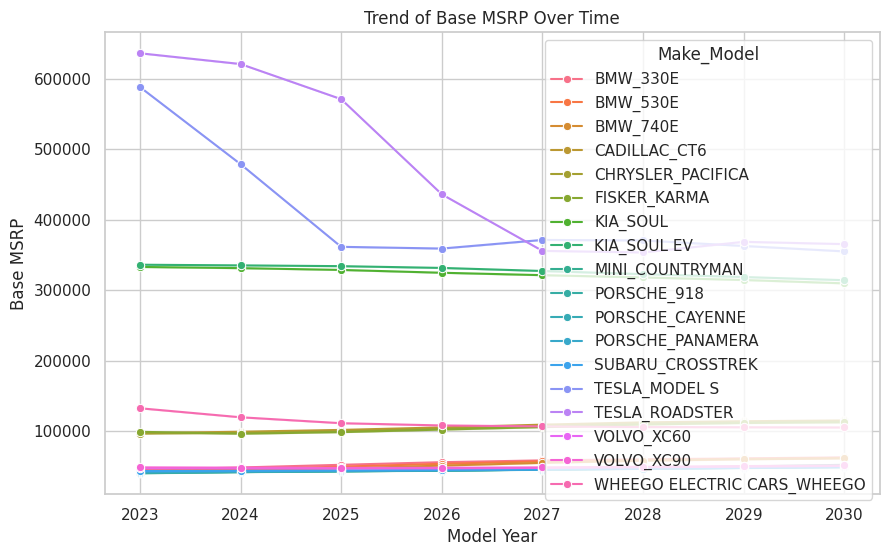

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_df, x="Model Year", y="Base MSRP", hue="Make_Model", marker="o")
plt.title("Trend of Base MSRP Over Time")
plt.ylabel("Base MSRP")
plt.xlabel("Model Year")
plt.legend(title="Make_Model")
plt.show()

<ipython-input-49-96c39c316546>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pred_df, y="Electric Vehicle Type", palette="viridis")


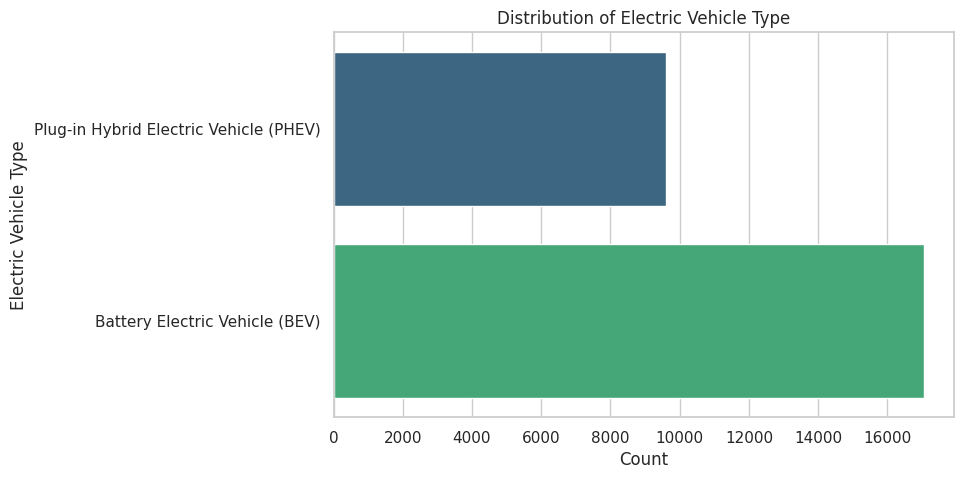

In [49]:
plt.figure(figsize=(8, 5))
sns.countplot(data=pred_df, y="Electric Vehicle Type", palette="viridis")
plt.title("Distribution of Electric Vehicle Type")
plt.ylabel("Electric Vehicle Type")
plt.xlabel("Count")
plt.show()

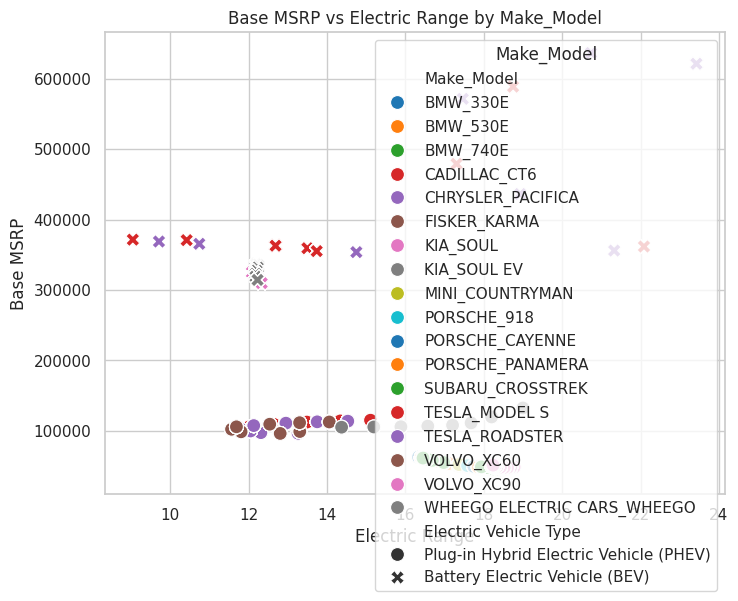

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pred_df,
    x="Electric Range",
    y="Base MSRP",
    hue="Make_Model",
    style="Electric Vehicle Type",
    palette="tab10",
    s=100,
)
plt.title("Base MSRP vs Electric Range by Make_Model")
plt.xlabel("Electric Range")
plt.ylabel("Base MSRP")
plt.legend(title="Make_Model")
plt.show()

In [51]:
cluster_source_df = source_df.copy()
cluster_source_df

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
30,KNDJX3AE9H,Thurston,Olympia,WA,98502,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,32250,22,140569600,PUGET SOUND ENERGY INC,53067012002,-122,47
71,KNDJX3AE5G,Snohomish,Edmonds,WA,98020,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,31950,32,158961099,PUGET SOUND ENERGY INC,53061050700,-122,47
187,5YJSA1DN6D,Yakima,Yakima,WA,98903,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,14,156737612,PACIFICORP,53077003003,-120,46
218,5YJSA1CG6D,Kitsap,Port Orchard,WA,98367,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,26,124244284,PUGET SOUND ENERGY INC,53035092902,-122,47
293,WBA8E1C52H,King,Tukwila,WA,98168,2017,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,44100,11,139331412,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033027300,-122,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177581,KNDJP3AE2G,King,Vashon,WA,98070,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,31950,34,146484964,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033027701,-122,47
177591,KNDJX3AE3H,Whatcom,Bellingham,WA,98225,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93,32250,40,251839507,PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM CO...,53073001101,-122,48
177605,5YJSA1DP4D,Pierce,Gig Harbor,WA,98335,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,26,231046714,BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072406,-122,47
177723,LYVBR0DK8K,King,Renton,WA,98055,2019,VOLVO,XC60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,17,52900,33,289237567,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033029309,-122,47


In [56]:
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [59]:
features = ['Electric Range', 'Base MSRP', 'Model Year', 'Longitude', 'Latitude', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Electric Range', 'Base MSRP', 'Model Year', 'Longitude', 'Latitude']),
        ('cat', OneHotEncoder(), ['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'])
    ])

param_grid = {
    'dbscan__eps': [0.1, 0.2, 0.3, 0.4, 0.5],
    'dbscan__min_samples': [3, 5, 10, 15]
}


dbscan = Pipeline(steps=[('preprocessor', preprocessor),
                         ('dbscan', DBSCAN())])

grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
best_cluster = None

In [60]:
for params in grid:
    dbscan.set_params(**params)

    dbscan.fit(cluster_source_df[features])

    num_clusters = len(set(dbscan.named_steps['dbscan'].labels_)) - (1 if -1 in dbscan.named_steps['dbscan'].labels_ else 0)

    print(f"Testing with eps={params['dbscan__eps']} and min_samples={params['dbscan__min_samples']} -> Found {num_clusters} clusters.")

    if num_clusters > best_score:
        best_score = num_clusters
        best_params = params
        best_cluster = dbscan.named_steps['dbscan'].labels_


print(f"\nBest parameters: eps={best_params['dbscan__eps']}, min_samples={best_params['dbscan__min_samples']}")
print(f"Best number of clusters: {best_score}")

Testing with eps=0.1 and min_samples=3 -> Found 102 clusters.
Testing with eps=0.1 and min_samples=5 -> Found 69 clusters.
Testing with eps=0.1 and min_samples=10 -> Found 45 clusters.
Testing with eps=0.1 and min_samples=15 -> Found 29 clusters.
Testing with eps=0.2 and min_samples=3 -> Found 101 clusters.
Testing with eps=0.2 and min_samples=5 -> Found 69 clusters.
Testing with eps=0.2 and min_samples=10 -> Found 45 clusters.
Testing with eps=0.2 and min_samples=15 -> Found 27 clusters.
Testing with eps=0.3 and min_samples=3 -> Found 101 clusters.
Testing with eps=0.3 and min_samples=5 -> Found 69 clusters.
Testing with eps=0.3 and min_samples=10 -> Found 45 clusters.
Testing with eps=0.3 and min_samples=15 -> Found 27 clusters.
Testing with eps=0.4 and min_samples=3 -> Found 95 clusters.
Testing with eps=0.4 and min_samples=5 -> Found 65 clusters.
Testing with eps=0.4 and min_samples=10 -> Found 43 clusters.
Testing with eps=0.4 and min_samples=15 -> Found 26 clusters.
Testing with 

In [62]:
cluster_source_df['Model_Name'] = cluster_source_df['Make'] + " " + cluster_source_df['Model']
cluster_source_df['Location'] = cluster_source_df['City'] + ", " + cluster_source_df['State']

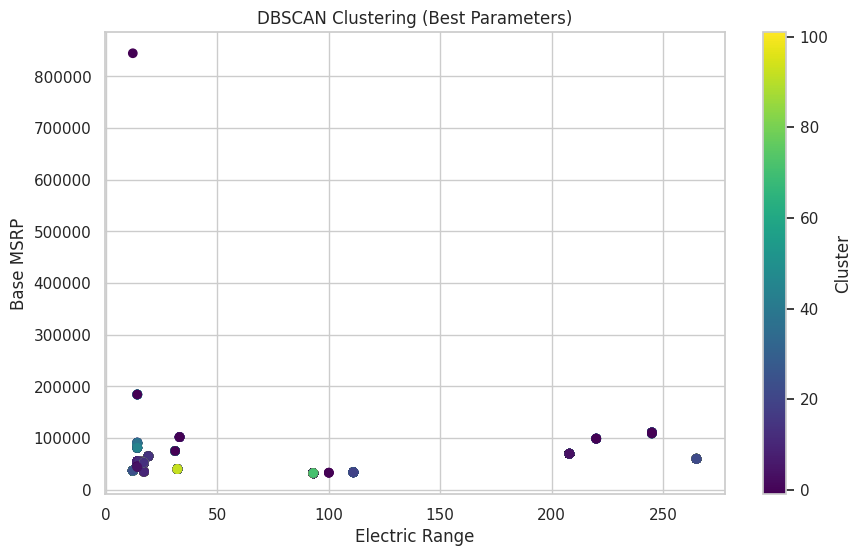

In [63]:
cluster_source_df['Cluster'] = best_cluster

plt.figure(figsize=(10, 6))
plt.scatter(cluster_source_df['Electric Range'], cluster_source_df['Base MSRP'], c=cluster_source_df['Cluster'], cmap='viridis')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.title('DBSCAN Clustering (Best Parameters)')
plt.colorbar(label='Cluster')
plt.show()

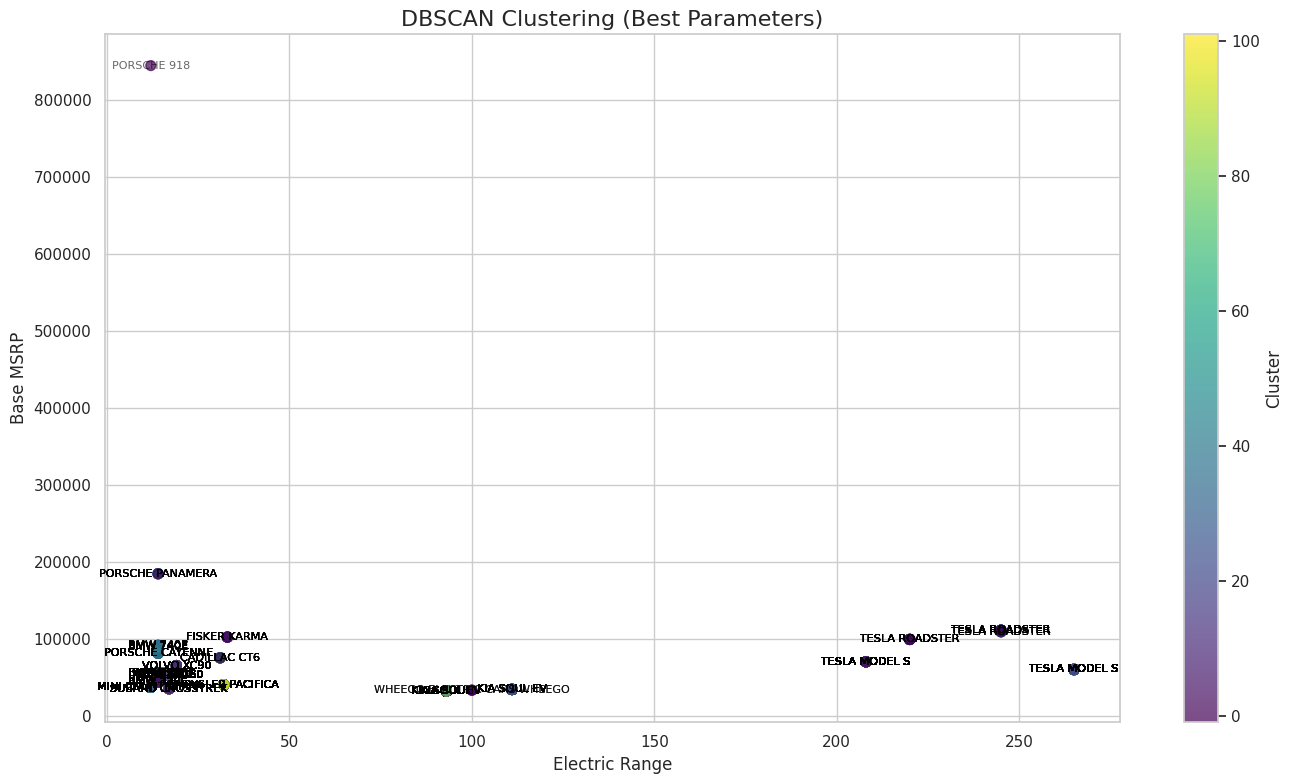

In [67]:
plt.figure(figsize=(14, 8))

scatter = plt.scatter(
    cluster_source_df['Electric Range'],
    cluster_source_df['Base MSRP'],
    c=cluster_source_df['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.7
)

plt.colorbar(scatter, label='Cluster')

# Use .iloc to access rows by index position
for i in range(len(cluster_source_df)):
    plt.annotate(
        cluster_source_df.iloc[i]['Model_Name'],  # Accessing by index position
        (cluster_source_df.iloc[i]['Electric Range'], cluster_source_df.iloc[i]['Base MSRP']),
        fontsize=8,
        alpha=0.6,
        color='black',
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.title('DBSCAN Clustering (Best Parameters)', fontsize=16)
plt.xlabel('Electric Range', fontsize=12)
plt.ylabel('Base MSRP', fontsize=12)

plt.tight_layout()
plt.show()

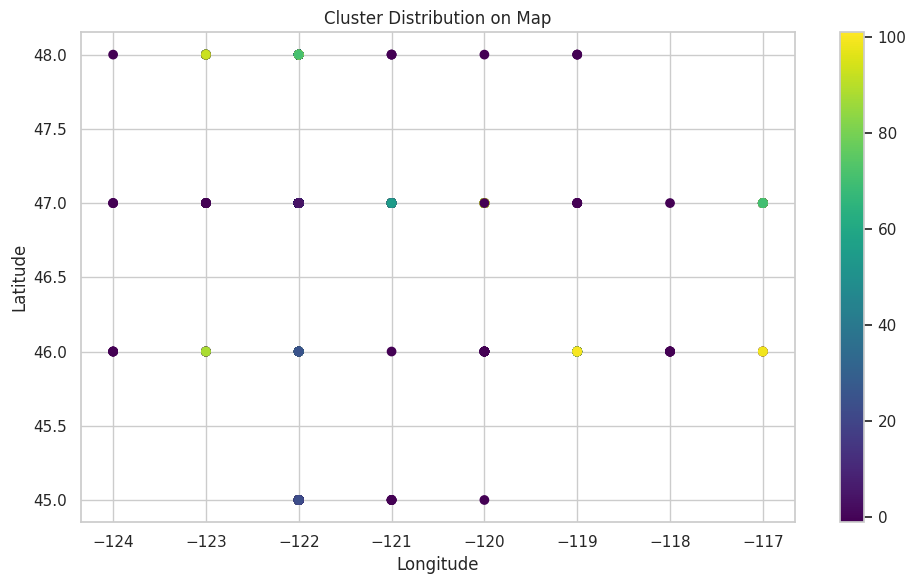

In [65]:
# Optionally, you could also plot location-based clusters using Longitude and Latitude

plt.figure(figsize=(10, 6))
plt.scatter(cluster_source_df['Longitude'], cluster_source_df['Latitude'], c=cluster_source_df['Cluster'], cmap='viridis')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Distribution on Map')

# Show the plot
plt.tight_layout()
plt.show()

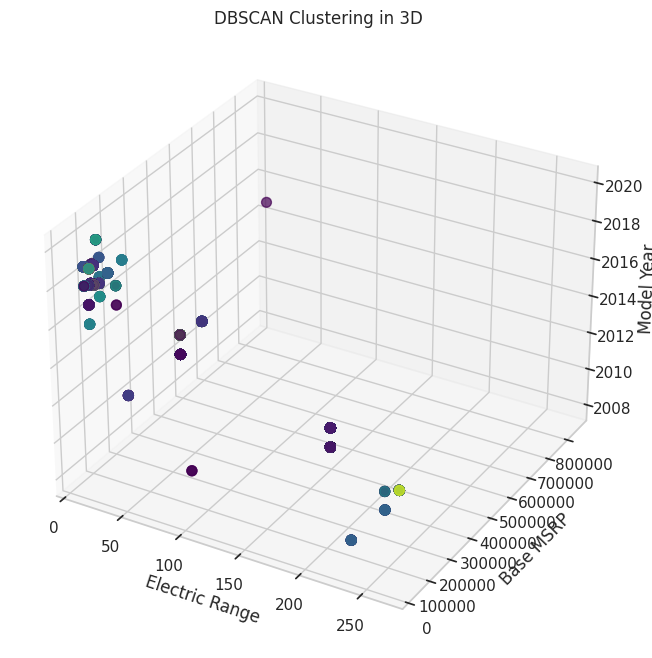

In [66]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    cluster_source_df['Electric Range'],
    cluster_source_df['Base MSRP'],
    cluster_source_df['Model Year'],
    c=cluster_source_df['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.7
)

ax.set_xlabel('Electric Range')
ax.set_ylabel('Base MSRP')
ax.set_zlabel('Model Year')
plt.title('DBSCAN Clustering in 3D')
plt.show()